In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import wbgapi as wb
import numpy as np
import seaborn as sns

## Read csv with raw covid data

In [2]:
data = pd.read_csv('raw_data.csv')
data = data[['iso_code', 'location', 'date', 'human_development_index', 'total_cases',
      'total_deaths', 'stringency_index', 'population']]
data.columns = ['code', 'country', 'date', 'hdi', 'tc', 'td', 'sti', 'population']
data

,code,country,date,hdi,tc,td,sti,population
0,AFG,Afghanistan,2019-12-31,0.498,0.0,0.0,0.00,38928341
1,AFG,Afghanistan,2020-01-01,0.498,0.0,0.0,0.00,38928341
2,AFG,Afghanistan,2020-01-02,0.498,0.0,0.0,0.00,38928341
3,AFG,Afghanistan,2020-01-03,0.498,0.0,0.0,0.00,38928341
4,AFG,Afghanistan,2020-01-04,0.498,0.0,0.0,0.00,38928341
...,...,...,...,...,...,...,...,...
50413,ZWE,Zimbabwe,2020-10-15,0.535,8055.0,231.0,76.85,14862927
50414,ZWE,Zimbabwe,2020-10-16,0.535,8075.0,231.0,76.85,14862927
50415,ZWE,Zimbabwe,2020-10-17,0.535,8099.0,231.0,76.85,14862927
50416,ZWE,Zimbabwe,2020-10-18,0.535,8110.0,231.0,76.85,14862927


## Process data

In [3]:
code = data.code.unique().tolist()
country = data.country.unique().tolist()
population = data['population'].unique().tolist()
hdi, tc, td, sti, gdp = [], [], [], [], []

for c in country:
    hdi.append((data.loc[data.country == c, 'hdi']).iloc[-1])
    tc.append((data.loc[data.country == c, 'tc']).iloc[-1])
    td.append((data.loc[data.country == c, 'td']).iloc[-1])
    sti.append((data.loc[data.country == c, 'sti']).mean())

agg_data = pd.DataFrame(list(zip(code, country, hdi, tc, td, sti, population)), 
                               columns = ["code", "country", "hdi", 
                                          "total_cases", "total_deaths", 
                                          "stringency_index", "population"]).set_index('code')
agg_data

,country,hdi,total_cases,total_deaths,stringency_index,population
code,,,,,,
AFG,Afghanistan,0.498,40200.0,1492.0,49.140036,38928341
ALB,Albania,0.785,17055.0,451.0,67.753460,2877800
DZA,Algeria,0.754,54402.0,1856.0,56.593182,43851043
AND,Andorra,0.858,3377.0,59.0,42.987897,77265
AGO,Angola,0.581,7462.0,241.0,77.841144,32866268
...,...,...,...,...,...,...
VEN,Venezuela,0.761,86636.0,736.0,83.584651,28435943
VNM,Vietnam,0.694,1134.0,35.0,56.615392,97338583
YEM,Yemen,0.452,2059.0,597.0,43.944839,29825968


## Get economic data from World Bank API

In [4]:
gdppcap = wb.data.DataFrame('NY.GDP.PCAP.CD')
gdppcap.columns = [e.replace('YR','') for e in gdppcap.columns]
gdppcap['gdp_fall'] = round((gdppcap['2020'] / gdppcap['2019'] - 1) * 100, 2)
gdp = gdppcap.iloc[:, -4:].round(2)
gdp

,2019,2020,2021,gdp_fall
economy,,,,
ABW,31135.88,23384.30,NaN,-24.90
AFE,1511.31,1360.88,1557.72,-9.95
AFG,494.18,516.75,NaN,4.57
AFW,1777.85,1709.76,1774.92,-3.83
AGO,2177.80,1631.43,2137.91,-25.09
...,...,...,...,...
XKX,4416.11,4310.81,4986.58,-2.38
YEM,750.55,631.68,690.76,-15.84
ZAF,6624.76,5655.87,6994.21,-14.63


## Concatenate covid data with economic data for each country

In [5]:
agg = agg_data.join(gdp, how='inner').sort_index().dropna(subset=['total_deaths'])
agg.insert(4, 'death_rate', round(agg.total_deaths / agg.total_cases, 4))
agg

,country,hdi,total_cases,total_deaths,death_rate,stringency_index,population,2019,2020,2021,gdp_fall
ABW,Aruba,NaN,4322.0,34.0,0.0079,53.102057,106766,31135.88,23384.30,NaN,-24.90
AFG,Afghanistan,0.498,40200.0,1492.0,0.0371,49.140036,38928341,494.18,516.75,NaN,4.57
AGO,Angola,0.581,7462.0,241.0,0.0323,77.841144,32866268,2177.80,1631.43,2137.91,-25.09
ALB,Albania,0.785,17055.0,451.0,0.0264,67.753460,2877800,5396.22,5332.16,6494.39,-1.19
AND,Andorra,0.858,3377.0,59.0,0.0175,42.987897,77265,40898.42,37416.70,43047.69,-8.51
...,...,...,...,...,...,...,...,...,...,...,...
VNM,Vietnam,0.694,1134.0,35.0,0.0309,56.615392,97338583,3425.09,3526.27,3694.02,2.95
YEM,Yemen,0.452,2059.0,597.0,0.2899,43.944839,29825968,750.55,631.68,690.76,-15.84
ZAF,South Africa,0.699,703793.0,18471.0,0.0262,63.881523,59308690,6624.76,5655.87,6994.21,-14.63
ZMB,Zambia,0.588,15853.0,346.0,0.0218,48.690299,18383956,1305.00,985.13,1120.63,-24.51


## Top 10 countries (total cases) to plot data

In [6]:
top10_cases = agg.sort_values('total_cases', ascending=False).head(10)
top10_cases

,country,hdi,total_cases,total_deaths,death_rate,stringency_index,population,2019,2020,2021,gdp_fall
USA,United States,0.924,8154595.0,219674.0,0.0269,52.458951,331002647,65094.80,63027.68,69287.54,-3.18
IND,India,0.640,7550273.0,114610.0,0.0152,62.824878,1380004385,2072.24,1933.10,2277.43,-6.71
BRA,Brazil,0.759,5235344.0,153905.0,0.0294,56.261729,212559409,8876.06,6814.88,7518.83,-23.22
RUS,Russia,0.816,1399334.0,24187.0,0.0173,52.052657,145934460,11536.25,10161.98,12172.79,-11.91
ARG,Argentina,0.825,989667.0,26267.0,0.0265,79.517686,45195777,10076.36,8585.69,10729.23,-14.79
COL,Colombia,0.747,959572.0,28970.0,0.0302,79.213509,50882884,6418.62,5312.20,6131.23,-17.24
ESP,Spain,0.891,936560.0,33775.0,0.0361,51.252797,46754783,29554.49,27056.42,30115.71,-8.45
FRA,France,0.901,897034.0,33477.0,0.0373,48.360283,65273512,40578.64,39037.12,43518.54,-3.80
PER,Peru,0.750,868675.0,33759.0,0.0389,82.470085,32971846,7023.08,6117.49,6692.25,-12.89
MEX,Mexico,0.774,851227.0,86167.0,0.1012,53.113014,128932753,9950.22,8431.67,9926.42,-15.26


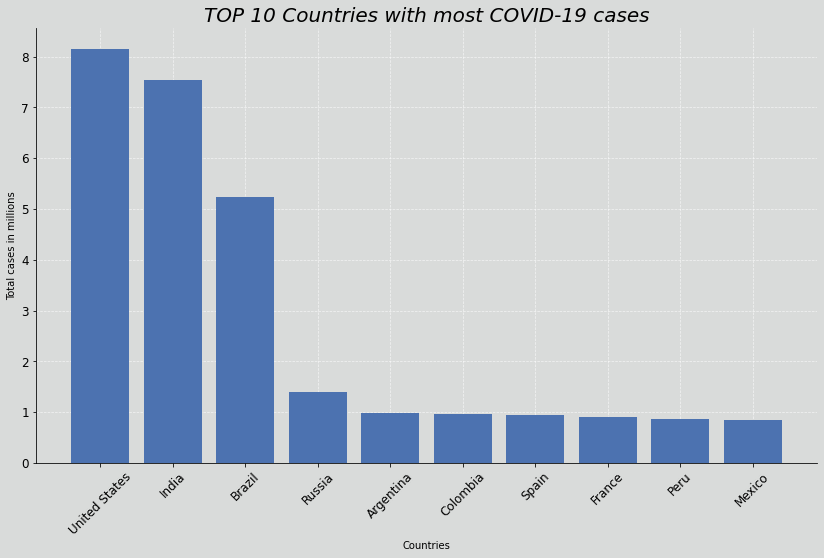

In [7]:
plt.rcParams["figure.facecolor"] = '#d9dbda'
fig, ax = plt.subplots(figsize=(14,8))
ax.set_facecolor('#d9dbda')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
ax.xaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
ax.bar(top10_cases.country, top10_cases.total_cases/10**6, color='#4c72b0', zorder=6)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Countries')
plt.ylabel('Total cases in millions')
plt.xticks(rotation = 45)
plt.title('TOP 10 Countries with most COVID-19 cases', size=20, style='italic')
plt.show()

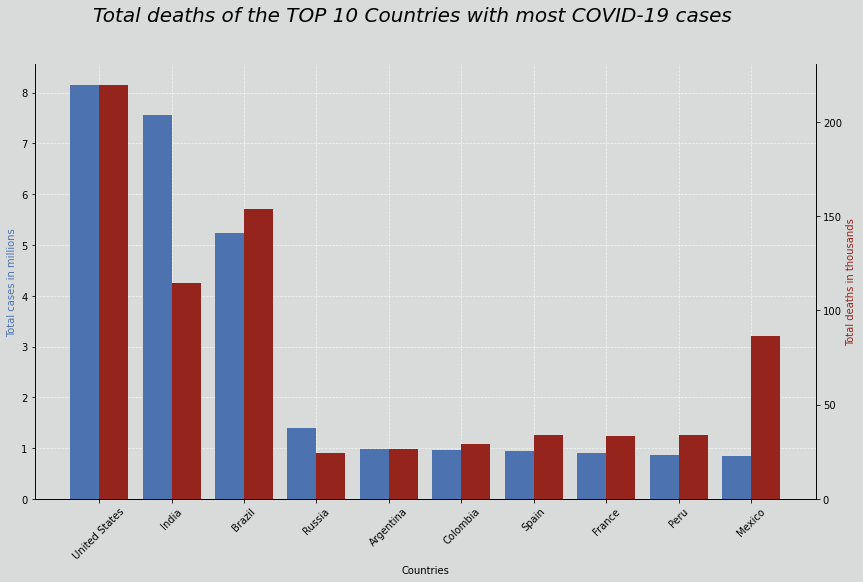

In [10]:
X_axis = np.arange(len(top10_cases.country))
plt.rcParams["figure.facecolor"] = '#d9dbda'

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_facecolor('#d9dbda')
ax1.spines['top'].set_visible(False)
ax1.yaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
ax1.xaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
ax1.bar(X_axis - 0.2, top10_cases.total_cases/10**6, 0.4, label = 'Cases', color='#4c72b0', zorder=3)
ax1.set_ylabel('Total cases in millions', color='#4c72b0')
plt.xticks(ticks=X_axis, labels=top10_cases.country, rotation = 45)
plt.xlabel('Countries')
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.bar(X_axis + 0.2, top10_cases.total_deaths/10**3, 0.4, label = 'Deaths',color='#94241c', zorder=3)
ax2.set_ylabel('Total deaths in thousands', color='#94241c')


plt.suptitle('Total deaths of the TOP 10 Countries with most COVID-19 cases', size=20, style='italic')
plt.show()

## Insight of covid reach in total population

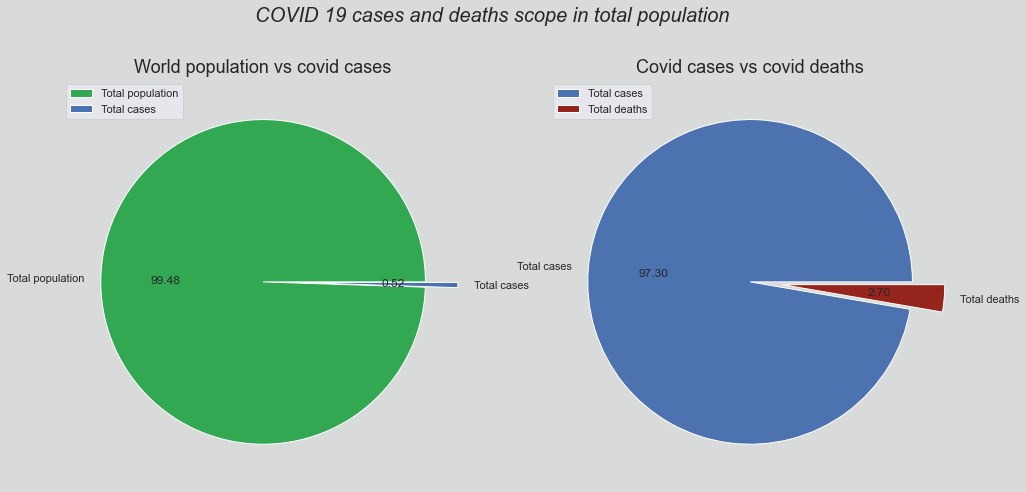

In [16]:
total_pop = agg.population.sum()
total_cases = agg.total_cases.sum()
total_deaths = agg.total_deaths.sum()
c_rate = [total_pop, total_cases]
d_rate = [total_cases, total_deaths]

plt.rcParams["figure.facecolor"] = '#d9dbda'
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.pie(c_rate, colors=['#32a852', '#4c72b0'], labels=['Total population', 'Total cases'], explode=[0, .2],
       autopct='%.2f')
plt.title('World population vs covid cases', size=18)
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.pie(d_rate, colors=['#4c72b0', '#94241c'], labels=['Total cases', 'Total deaths'], explode=[0, .2],
       autopct='%.2f')
plt.suptitle('COVID 19 cases and deaths scope in total population', size=20, style='italic')
plt.title('Covid cases vs covid deaths', size=18)
plt.legend(loc='upper left')
plt.show()

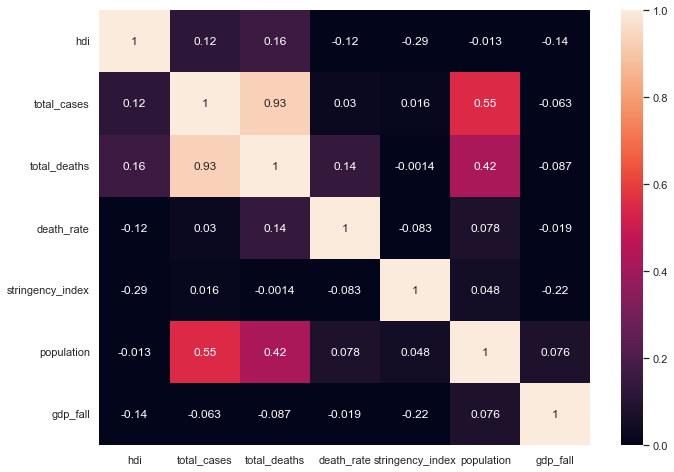

In [23]:
df = agg[['hdi', 'total_cases', 'total_deaths', 'death_rate', 'stringency_index',
          'population', 'gdp_fall']].corr()

sns.set(rc = {'figure.figsize':(11,8)})
sns.heatmap(df, vmin=0, vmax=1, annot=df)
plt.show()


The r2 -correlation- between covid cases and GDP fall in the 15 countries more affected is: 28.54%



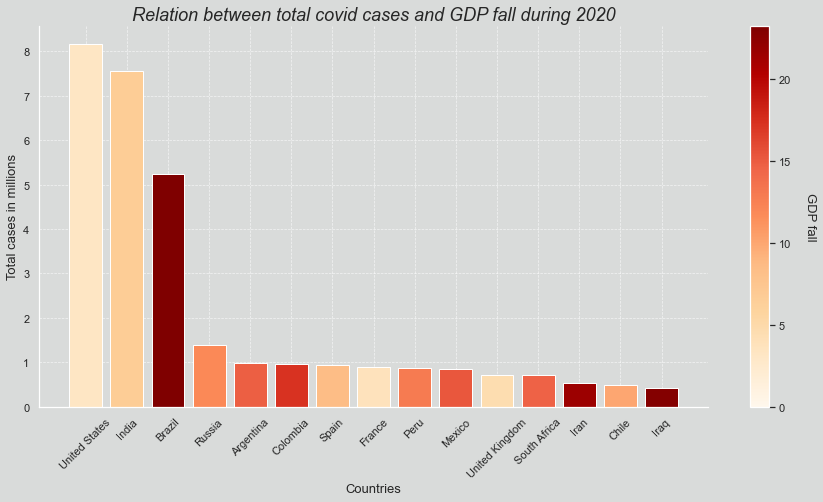

In [25]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

df = agg.sort_values('total_cases',ascending=False).head(15)

plt.rcParams["figure.facecolor"] = '#d9dbda'
plt.rcParams['axes.grid'] = False
r2 = df.total_cases.corr(df.gdp_fall) * 100

x = df.country
y = df.total_cases / 10**6
cmap = df.gdp_fall.abs()

cmap_norm = [e / max(cmap) for e in cmap]

fig, ax = plt.subplots(figsize=(15, 7))

my_cmap = plt.cm.get_cmap('OrRd')
colors = my_cmap(cmap_norm)

ax.bar(x, y, color=colors)
ax.set_facecolor('#d9dbda')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
ax.xaxis.grid(color='white', linestyle='dashed', alpha=0.7, lw=.7, zorder=0)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(cmap)))

sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('GDP fall', rotation=270,labelpad=25, size=13)

plt.xticks(x, rotation=45)    
plt.ylabel("Total cases in millions", size=13)
plt.xlabel('Countries', size=13)

plt.title('Relation between total covid cases and GDP fall during 2020', size=18, style='italic')

print(f'\nThe r2 -correlation- between covid cases and GDP fall in the 15 countries more affected \
is: {"{:.2f}%".format(r2)}\n')
plt.show()